In [1]:
using Plots
using LinearAlgebra
using Parameters
using MyLibrary
using Roots
using Interpolations

In [124]:
module My

using Parameters 

@with_kw struct PhysicalParam{T} @deftype Float64
    ħc = 197
    mc² = 938
    
    var"ρ/ρ₀" = 1.0
    ρ₀ = (1.36)^3/3π^2
    ρ = var"ρ/ρ₀"*ρ₀
    kF = (3π^2*ρ)^(1/3)
    eF = ħc^2/2mc² * kF^2
    
    Δk = 0.05
    Nk::Int64 = 400
    ks::T = range(Δk, Nk*Δk, length=Nk)
    
    Δr = 0.1
    Nr::Int64 = 200
    rs::T = range(Δr, Nr*Δr, length=Nr)
    
    # Gogny D1 parameters
    W::Vector{Float64} = [-402.4, -21.30]
    B::Vector{Float64} = [-100.0, -11.77]
    H::Vector{Float64} = [-496.2, 37.27]
    M::Vector{Float64} = [-23.56, -68.81]
    vs_Gogny::Vector{Float64} = @. W - B - H + M
    as_Gogny::Vector{Float64} = [0.7, 1.2]
    
    # G3RS parameters
    vs_G3RS::Vector{Float64} = [2000, -270, -5]
    as_G3RS::Vector{Float64} = [0.447, 0.942, 2.5]
    
    interaction::Symbol = :G3RS; @assert interaction==:Gogny || interaction==:G3RS
    
    vs::Vector{Float64} = interaction==:G3RS ? vs_G3RS : vs_Gogny
    as::Vector{Float64} = interaction==:G3RS ? as_G3RS : as_Gogny; @assert length(vs) === length(as)
end

end # module My

Main.My

In [125]:
param = My.PhysicalParam(interaction=:Gogny)

Main.My.PhysicalParam{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}
  ħc: Float64 197.0
  mc²: Float64 938.0
  ρ/ρ₀: Float64 1.0
  ρ₀: Float64 0.0849563264400735
  ρ: Float64 0.0849563264400735
  kF: Float64 1.36
  eF: Float64 38.26286055437101
  Δk: Float64 0.05
  Nk: Int64 400
  ks: StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}
  Δr: Float64 0.1
  Nr: Int64 200
  rs: StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}
  W: Array{Float64}((2,)) [-402.4, -21.3]
  B: Array{Float64}((2,)) [-100.0, -11.77]
  H: Array{Float64}((2,)) [-496.2, 37.27]
  M: Array{Float64}((2,)) [-23.56, -68.81]
  vs_Gogny: Array{Float64}((2,)) [170.24, -115.61000000000001]
  as_Gogny: Array{Float64}((2,)) [0.7, 1.2]
  vs_G3RS: Array{Float64}((3,)) [2000.0, -270.0, -5.0]
  as_G3RS: Array{Float64}((3,)) [0.447, 0.942, 2.5]
  interaction: Symbol Gogny
  vs: Array{Float64}((2,)) [170.24, -115.61000000000001]
  as

### interaction in ${^{1}S}$-channel
$$
    v(r) = \sum_{i} v_{i} e^{-r^2/a_{i}^{2}}
$$

In [120]:
function calc_potential(param, rs)
    @unpack vs, as = param
    vpot = zeros(Float64, length(rs))
    for i in 1:length(vs)
        @. vpot += vs[i] * exp(-rs*rs/(as[i]*as[i]))
    end
    return vpot
end

calc_potential (generic function with 1 method)

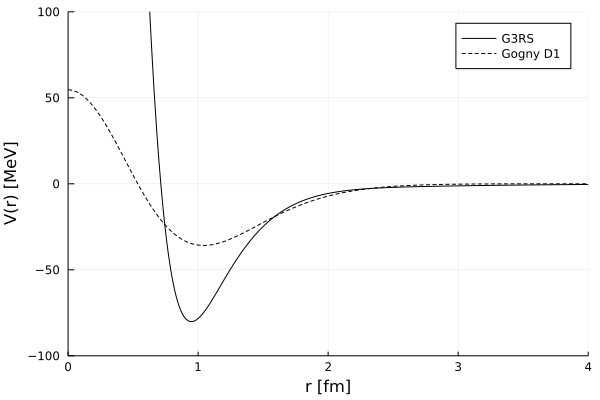

In [122]:
rs = range(0, 4, step=0.01)

param_G3RS = My.PhysicalParam(interaction=:G3RS)
vpot_G3RS = calc_potential(param_G3RS, rs)

param_Gogny = My.PhysicalParam(interaction=:Gogny)
vpot_Gogny = calc_potential(param_Gogny, rs)

p = plot(;xlim=(0,4), ylim=(-100,100), xlabel="r [fm]", ylabel="V(r) [MeV]")
plot!(p, rs, vpot_G3RS; label="G3RS", color=:black)
plot!(p, rs, vpot_Gogny; label="Gogny D1", color=:black, line=:dash)
display(p)
#savefig("di-neutron in nuclear matter figure/G3RS_GognyD1.png")

In [4]:
function free_particle_spectrum(param)
    @unpack ħc, mc², Nk, ks = param 
    es = similar(ks)
    @. es = ħc^2/2mc² * ks^2
end

function test_free_particle_spectrum(param)
    @unpack ks = param
    @time es = free_particle_spectrum(param)
    plot(ks, es)
end

test_free_particle_spectrum (generic function with 1 method)

  0.000007 seconds (1 allocation: 3.250 KiB)


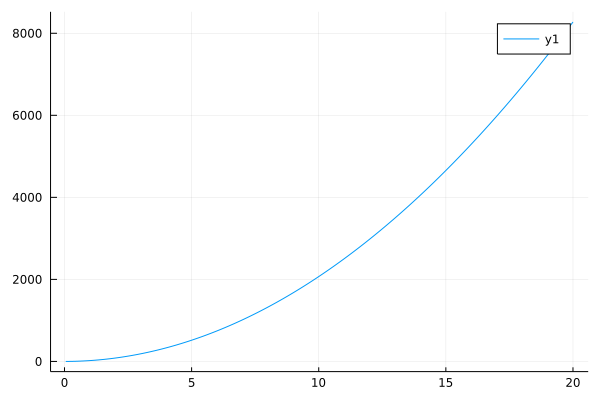

In [5]:
test_free_particle_spectrum(param)

### number equation 
$$
    \rho = \frac{1}{2\pi^{2}} \int_{0}^{\infty} dk\, k^{2} 
    \left(1 - \frac{e(k) - \mu}{E(k)}\right)
$$

In [6]:
function number_equation(param, es, Δs, μ)
    @unpack ρ, Δk, Nk, ks = param 
    
    f = 0.0
    for ik in 1:Nk
        k = ks[ik]
        e = es[ik]
        Δ = Δs[ik]
        E = sqrt((e-μ)^2 + Δ^2)
        f += Δk*k*k*(1 - (e-μ)/E)
    end
    f *= 1/2π^2
    f -= ρ
end

function test_number_equation(param, Δ, μs)
    @unpack eF, Nk = param
    Δs = fill(Δ, Nk)
    
    es = free_particle_spectrum(param)
    
    Nμ = length(μs)
    fs = similar(μs)
    
    @time for iμ in 1:Nμ
        fs[iμ] = number_equation(param, es, Δs, μs[iμ])
    end
    
    @show eF
    
    plot(μs, fs; label="number equation")
    plot!(μs, fill(0, length(μs)); label="0")
    plot!([eF], [0]; marker=:dot, label="eF")
end



test_number_equation (generic function with 1 method)

  0.017326 seconds
eF = 38.26286055437101


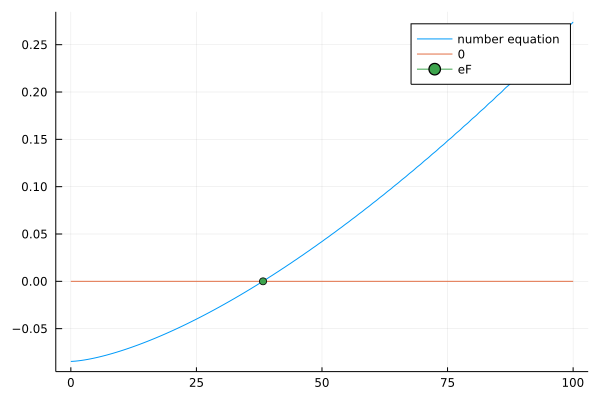

In [8]:
Δ = 1.0
μs = range(0, 100, length=2000)
param = My.PhysicalParam(Nk=1000, Δk=0.02, var"ρ/ρ₀"=1.0)
test_number_equation(param, Δ, μs)

In [9]:
function solve_number_equation(param, es, Δs; μ_min=-param.eF*10000, μ_max=param.eF*100)
    f(μ) = number_equation(param, es, Δs, μ)
    if f(μ_min)*f(μ_max) > 0
        @show f(μ_min) f(μ_max)
        μs = range(μ_min, μ_max, length=1000)
        p = plot()
        #p = plot(ks, Δs)
        plot!(p, μs, f.(μs))
        display(p)
    end
    find_zero(f, (μ_min, μ_max), Bisection())
end

function test_solve_number_equation(param, Δ)
    @unpack eF, Nk = param
    Δs = fill(Δ, Nk)
    es = free_particle_spectrum(param)
    
    @time μ = solve_number_equation(param, es, Δs)
    @show μ eF
    return 
end

test_solve_number_equation (generic function with 1 method)

In [13]:
Δ= 1.0
param = My.PhysicalParam(Nk=1000, Δk=0.02, var"ρ/ρ₀"=1.0)
test_solve_number_equation(param, Δ)

  0.000777 seconds (26 allocations: 1.688 KiB)
μ = 38.22373819774362
eF = 38.26286055437101


### gap equation 

$$
    \Delta(p) = 
    - \sum_{i} \frac{v_{i} \mu_{i}}{4 \sqrt{\pi} p}
    \int_{0}^{\infty} dk \, k \left[
    e^{-\mu_{i}^{2}(p-k)^{2}/4} 
    - e^{-\mu_{i}^{2}(p+k)^{2}/4}
    \right] \frac{\Delta(k)}{E(k)}
$$

In [16]:
function calc_gap!(Δs_new, param, es, Δs, μ)
    @unpack Δk, Nk, ks, vs, as = param
    
    fill!(Δs_new, 0)
    for i in 1:length(vs), ip in 1:Nk, ik in 1:Nk
        v = vs[i]
        a = as[i]
        
        p = ks[ip]
        
        k = ks[ik]
        Δ = Δs[ik]
        E = sqrt((es[ik]-μ)^2 + Δ^2)
        
        Δs_new[ip] += -v*a/(4*√π*p)*Δk*k*
            (exp(-(1/4)*a^2*(p-k)^2) - exp(-(1/4)*a^2*(p+k)^2))*Δ/E
    end
    
    return
end

function test_calc_gap(param, Δ₀)
    @unpack eF, Nk, ks = param
    Δs = fill(Δ₀, Nk)
    es = free_particle_spectrum(param)
    
    μ = solve_number_equation(param, es, Δs)
    
    Δs_new = similar(Δs)
    @time calc_gap!(Δs_new, param, es, Δs, μ)
    
    p = plot()
    plot!(p, ks, Δs; label="Δs")
    plot!(p, ks, Δs_new; label="Δs_new")
end
     

test_calc_gap (generic function with 1 method)

  0.090546 seconds


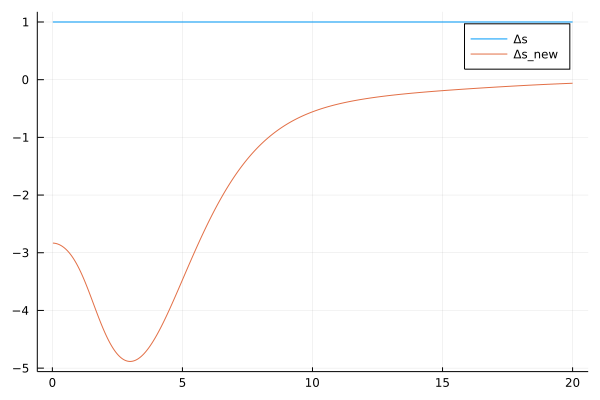

In [22]:
Δ₀ = 1.0
test_calc_gap(param, Δ₀)

In [52]:
function solve_gap_equation!(Δs, Δs_new, param, es; iter_max=1000, χ=0.3, rtol=1e-5, show_result=false)
    @unpack ks = param
    μ = solve_number_equation(param, es, Δs)
    
    Δ²_diff = Float64[]
    
    n_plot = 10
    plot_interval = div(iter_max, n_plot)
    
    #p = plot(xlabel="k [fm⁻¹]", ylabel="Δ [MeV]")
    for iter in 1:iter_max
        calc_gap!(Δs_new, param, es, Δs, μ)
        #=
        if (iter%n_plot === 0)
            plot!(p, ks, Δs_new)
        end
        =#
        
        Δ = sum(@. Δs^2)
        Δ_new = sum(@. Δs_new^2)
        push!(Δ²_diff, Δ-Δ_new)
        if iter > 1 && isapprox(Δ, Δ_new, rtol=rtol)
            if show_result
                println("iteration converged at iter=$iter")
            end
            break
        end
        
        if iter > 1 
            @. Δs = (Δs + χ*Δs_new)/(1 + χ)
        else
            @. Δs = Δs_new
        end
        
        μ = solve_number_equation(param, es, Δs)
        
        #=
        if (iter%plot_interval === 0)
            #@show Δ Δ_new
            plot!(p, ks, Δs)
        end
        =#
    end
    #display(p)
    
    if show_result
        p = plot(xlabel="k [fm⁻¹]", ylabel="Δ [MeV]")
        plot!(p, ks, Δs)
        display(p)
    end
    
    #=
    p = plot(Δ²_diff; xlabel="iter", ylabel="|Δs|² - |Δs_new|² [MeV²]")
    display(p)
    =#
    
    return μ
end

function test_solve_gap_equation(param, Δ₀; iter_max=100, χ=0.1, rtol=1e-5, show_result=true)
    @unpack eF, kF, Nk, ks = param
    es = free_particle_spectrum(param)
    
    Δs = fill(Δ₀, Nk)
    Δs_new = similar(Δs)
    
    @time solve_gap_equation!(Δs, Δs_new, param, es; iter_max=iter_max, χ=χ, rtol=rtol, show_result=show_result)
    
    itp_Δs = CubicSplineInterpolation(ks, Δs)
    @show kF itp_Δs(kF)
    
    return 
end

test_solve_gap_equation (generic function with 1 method)

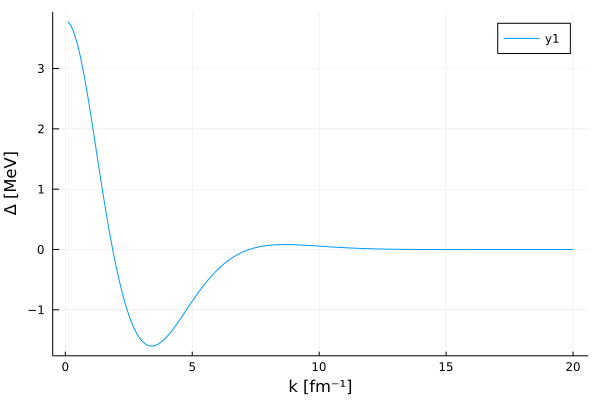

iteration converged at iter=149
  0.742000 seconds (54.04 k allocations: 2.139 MiB)
kF = 0.7953328247938997
itp_Δs(kF) = 2.7602633513603587


In [127]:
Δ₀ = 1.0
param = My.PhysicalParam(var"ρ/ρ₀"=0.2, Nk=200, Δk=0.1)
test_solve_gap_equation(param, Δ₀; iter_max=1000, χ=0.3, rtol=1e-5, show_result=true)

In [128]:
# solve gap equation for G3RS with m*/m = 1

var"ρ/ρ₀" = 10 .^ range(-4, 0, step=0.10)
ΔF_G3RS_free = similar(var"ρ/ρ₀")
eF = similar(var"ρ/ρ₀")

Nk = 400
Δk = 0.05

for i in 1:length(var"ρ/ρ₀")
    param = My.PhysicalParam(var"ρ/ρ₀"=var"ρ/ρ₀"[i], Nk=Nk, Δk=Δk, interaction=:G3RS)
    es = free_particle_spectrum(param)
    
    Δs = fill(Δ₀, param.Nk)
    Δs_new = similar(Δs)
    solve_gap_equation!(Δs, Δs_new, param, es)
    
    itp_Δs = CubicSplineInterpolation(param.ks, Δs)
    @show ΔF_G3RS_free[i] = abs(itp_Δs(param.kF)) 
    @show eF[i] = param.eF 
    println("")
end

ΔF_G3RS_free[i] = abs(itp_Δs(param.kF)) = 0.019706261296723846
eF[i] = param.eF = 0.08243483411818951

ΔF_G3RS_free[i] = abs(itp_Δs(param.kF)) = 0.016632418212607906
eF[i] = param.eF = 0.0961119602572677

ΔF_G3RS_free[i] = abs(itp_Δs(param.kF)) = 0.01881869747876999
eF[i] = param.eF = 0.1120583185895721

ΔF_G3RS_free[i] = abs(itp_Δs(param.kF)) = 0.04058039221201064
eF[i] = param.eF = 0.13065040741557968

ΔF_G3RS_free[i] = abs(itp_Δs(param.kF)) = 0.05477700386203306
eF[i] = param.eF = 0.15232719152583662

ΔF_G3RS_free[i] = abs(itp_Δs(param.kF)) = 0.06674183089042518
eF[i] = param.eF = 0.1776004662912514

ΔF_G3RS_free[i] = abs(itp_Δs(param.kF)) = 0.07733948754744371
eF[i] = param.eF = 0.20706694130522327

ΔF_G3RS_free[i] = abs(itp_Δs(param.kF)) = 0.08651840408380362
eF[i] = param.eF = 0.2414223288760188

ΔF_G3RS_free[i] = abs(itp_Δs(param.kF)) = 0.09449187144391039
eF[i] = param.eF = 0.28147777000292373

ΔF_G3RS_free[i] = abs(itp_Δs(param.kF)) = 0.11301610787430234
eF[i] = param.eF = 0.3

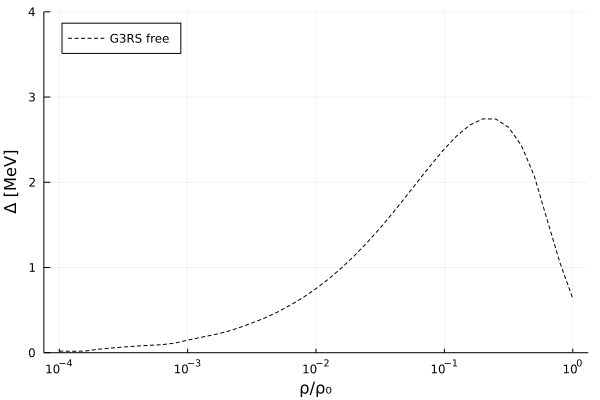

In [129]:
p = plot(;ylim=(0,4), xaxis=:log, xlabel="ρ/ρ₀", ylabel="Δ [MeV]", legend=:topleft)
plot!(p, var"ρ/ρ₀", ΔF_G3RS_free; label="G3RS free", color=:black, line=:dash)
display(p)

#=
p = plot(var"ρ/ρ₀", (@. ΔF/eF * 100); xaxis=:log, xlabel="ρ/ρ₀", ylabel="Δ(kF)/eF [%]")
display(p)
=#

In [130]:
# solve gap equation for Gogny D1 with m*/m = 1

var"ρ/ρ₀" = 10 .^ range(-4, 0, step=0.10)
ΔF_Gogny_free = similar(var"ρ/ρ₀")
eF = similar(var"ρ/ρ₀")

Nk = 400
Δk = 0.05


for i in 1:length(var"ρ/ρ₀")
    param = My.PhysicalParam(var"ρ/ρ₀"=var"ρ/ρ₀"[i], Nk=Nk, Δk=Δk, interaction=:Gogny)
    es = free_particle_spectrum(param)
    
    Δs = fill(Δ₀, param.Nk)
    Δs_new = similar(Δs)
    solve_gap_equation!(Δs, Δs_new, param, es)
    
    itp_Δs = CubicSplineInterpolation(param.ks, Δs)
    @show ΔF_Gogny_free[i] = abs(itp_Δs(param.kF)) 
    @show eF[i] = param.eF 
    println("")
end

ΔF_Gogny_free[i] = abs(itp_Δs(param.kF)) = 0.016240031912796927
eF[i] = param.eF = 0.08243483411818951

ΔF_Gogny_free[i] = abs(itp_Δs(param.kF)) = 0.013282946574466308
eF[i] = param.eF = 0.0961119602572677

ΔF_Gogny_free[i] = abs(itp_Δs(param.kF)) = 0.01583128154373864
eF[i] = param.eF = 0.1120583185895721

ΔF_Gogny_free[i] = abs(itp_Δs(param.kF)) = 0.035063529499036045
eF[i] = param.eF = 0.13065040741557968

ΔF_Gogny_free[i] = abs(itp_Δs(param.kF)) = 0.047805183808066115
eF[i] = param.eF = 0.15232719152583662

ΔF_Gogny_free[i] = abs(itp_Δs(param.kF)) = 0.05840311729458767
eF[i] = param.eF = 0.1776004662912514

ΔF_Gogny_free[i] = abs(itp_Δs(param.kF)) = 0.06743635176651654
eF[i] = param.eF = 0.20706694130522327

ΔF_Gogny_free[i] = abs(itp_Δs(param.kF)) = 0.07442616701346846
eF[i] = param.eF = 0.2414223288760188

ΔF_Gogny_free[i] = abs(itp_Δs(param.kF)) = 0.0778451624145956
eF[i] = param.eF = 0.28147777000292373

ΔF_Gogny_free[i] = abs(itp_Δs(param.kF)) = 0.09246887329570533
eF[i] = par

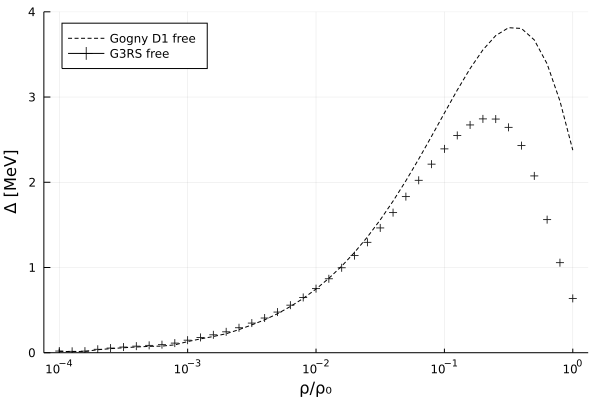

In [136]:
p = plot(;ylim=(0,4), xaxis=:log, xlabel="ρ/ρ₀", ylabel="Δ [MeV]", legend=:topleft)
plot!(p, var"ρ/ρ₀", ΔF_Gogny_free; label="Gogny D1 free", color=:black, line=:dash)
plot!(p, var"ρ/ρ₀", ΔF_G3RS_free; label="G3RS free", color=:black, line=false, marker=:+)
display(p)

### Cooper pair wave function 
\begin{align}
    \Psi_{\mathrm{pair}}(r)
    &= \frac{C}{(2\pi)^{3}} \int d^{3}{k} \frac{\Delta(k)}{2E(k)} 
    e^{i \vec{k} \cdot \vec{r}}
    \\
    &= \frac{C}{4\pi^{2}r} \int_{0}^{\infty} dk\, k 
    \frac{\Delta(k)}{E(k)} \sin (kr)
\end{align}

### norm 
\begin{align}
    \int d^{3}r \, |\Psi_{\mathrm{pair}}(r)|^{2}
    = \frac{|C|^{2}}{2\pi^{2}} \int_{0}^{\infty} dk \, k^{2}
    \left(\frac{\Delta(k)}{2E(k)}\right)^{2}
\end{align}

### root-mean-square radius
\begin{align}
    \xi_{rms}^{2}
    = \frac{
        \displaystyle
        \int_{0}^{\infty} dk \, k^{2}
        \left(
            \frac{\partial}{\partial k} 
            \frac{\Delta(k)}{E(k)}
        \right)^{2}
    }{
        \displaystyle
        \int_{0}^{\infty} dk \, k^{2}
        \left(\frac{\Delta(k)}{E(k)}\right)^{2}
    }
\end{align}

In [ ]:
function calc_norm(param, es, Δs, μ)
    @unpack Δk, Nk, ks = param 
    
    N² = 0.0
    for ik in 1:Nk
        k = ks[ik]
        Δ = Δs[ik]
        E = sqrt((es[ik]-μ)^2 + Δ^2)
        
        N += Δk*k*k*(Δ/2E)^2
    end
    N² *= 1/2π^2
    
    N = sqrt(N²)
end

function calc_rmsr(param, es, Δs, μ)
    @unpack Δk, Nk, ks = param 
    
    ξ² = 0.0
    
    k = ks[1]
    ξ² += Δk*k*k*()
    
    for ik in 1:Nk
        ξ² += Δk*k*k*
    
    
    

In [117]:
function calc_wave_function!(ψ, param, es, Δs, μ)
    @unpack Δk, Nk, ks, Δr, Nr, rs = param
    
    fill!(ψ, 0)
    for ir in 1:Nr, ik in 1:Nk 
        r = rs[ir]
        
        k = ks[ik]
        Δ = Δs[ik]
        E = sqrt((es[ik]-μ)^2 + Δ^2)
        
        ψ[ir] += 1/(4π^2*r)*Δk*k*(Δ/E)*sin(k*r)
    end
    
    # normalization 
    C = sqrt(sum(@. rs^2*ψ^2))
    @. ψ /= C
    return 
end

function calc_rmsr(param, ψ)
    @unpack Δr, Nr, rs = param 
    
    ξ = sqrt(sum(@. rs^4*ψ^2)/sum(@. rs^2*ψ^2))
end

function test_calc_wave_function(param)
    @unpack eF, kF, Nk, ks, rs = param
    es = free_particle_spectrum(param)
    
    Δs = fill(Δ₀, Nk)
    Δs_new = similar(Δs)
    
    param = My.PhysicalParam(var"ρ/ρ₀"=param.var"ρ/ρ₀", Nr=param.Nr, interaction=:G3RS)
    @time μ = solve_gap_equation!(Δs, Δs_new, param, es)
    ψ_G3RS_free = similar(rs)
    @time calc_wave_function!(ψ_G3RS_free, param, es, Δs, μ)
    
    
    param = My.PhysicalParam(var"ρ/ρ₀"=param.var"ρ/ρ₀", Nr=param.Nr, interaction=:Gogny)
    @time μ = solve_gap_equation!(Δs, Δs_new, param, es)
    ψ_Gogny_free = similar(rs)
    @time calc_wave_function!(ψ_Gogny_free, param, es, Δs, μ)
    
    p = plot(;xlabel="r [fm]", ylabel="ψ [fm^-3/2]", xlim=(0,20))
    plot!(p, rs, ψ_G3RS_free; label="G3RS free")
    plot!(p, rs, ψ_Gogny_free; label="Gogny free")
    display(p)
    
    #=
    p = plot(;xlabel="r [fm]", ylabel="r²ψ² [fm⁻¹]")
    plot!(p, rs, (@. rs^2*ψ^2))
    display(p)
    =#
end

test_calc_wave_function (generic function with 1 method)

  3.417723 seconds (5.63 k allocations: 1.801 MiB)
  0.150393 seconds (79.60 k allocations: 4.317 MiB, 98.07% compilation time)


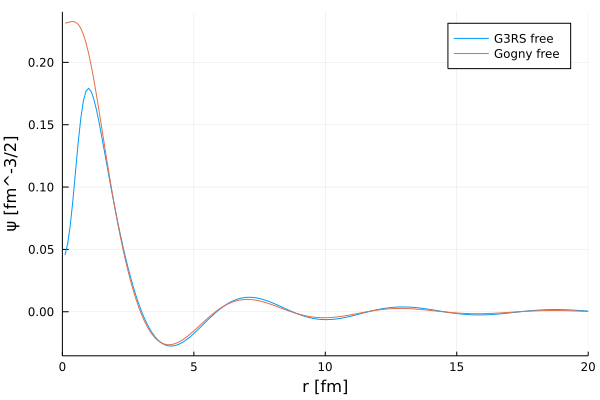

  1.310494 seconds (2.94 k allocations: 960.781 KiB)
  0.002692 seconds (2 allocations: 2.047 KiB)


In [118]:
param = My.PhysicalParam(var"ρ/ρ₀"=1/2, Nr=200)
test_calc_wave_function(param)